# Assignment - Part 2

Alexandre Vilhena da Costa \
Tiago Marques Claro

## Data Organization

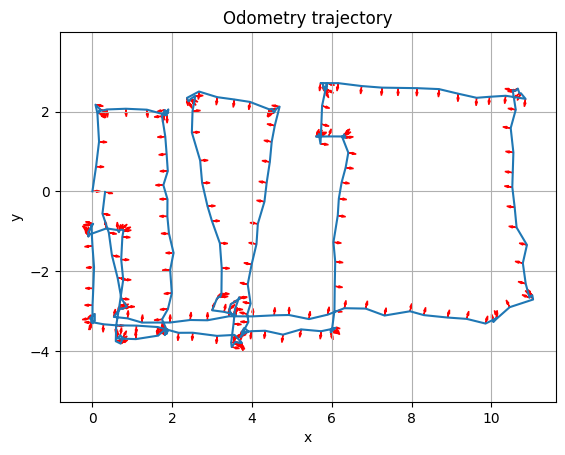

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
data = np.loadtxt('data_slam.txt')

# Extract the robots pose variations delta_x, delta_y, delta_theta (noisy measurements) and the lidar measurements
pose = data[:, 0:3]
lidar = data[:, 3:]

# Initialize arrays for real positions
x = [0]  # Start at origin (x0)
y = [0]  # Start at origin (y0)
theta = [0]  # Start with initial orientation (theta0)

# Calculate real positions
for i in range(len(pose)):
	x.append(x[i] + pose[i, 0])
	y.append(y[i] + pose[i, 1])
	theta.append(theta[i] + pose[i, 2])

# Convert lists to numpy arrays for easier handling
x = np.array(x[:-1])
y = np.array(y[:-1])
theta = np.array(theta[:-1])

# Plot the real trajectory with an arrow indicating the theta direction
plt.figure()
plt.plot(x, y)

for i in range(0, len(x)):
	plt.arrow(x[i], y[i], 0.1*np.cos(theta[i]), 0.1*np.sin(theta[i]), head_width=0.05, head_length=0.1, fc='r', ec='r')

plt.title('Odometry trajectory')
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')
plt.grid()
plt.show()

## Plot the map captured by the LiDAR

In [32]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from scipy.spatial import KDTree

def find_corners(line1, line2, ang_treshold=5):
    m1, b1 = line1
    m2, b2 = line2
    ang = np.arctan(np.abs((m2-m1)/(1+m1*m2)))
    ang = ang * 180 / np.pi
    print(ang)
    if 90 - ang_treshold < ang < 90 + ang_treshold:
        x = (b2-b1)/(m1-m2)
        y = m1*x + b1
        return (x, y)
    
    return None

def cluster2line(cluster):
    x_cluster, y_cluster = cluster[:, 0], cluster[:, 1]
    A = np.vstack([x_cluster, np.ones(len(x_cluster))]).T
    m, b = np.linalg.lstsq(A, y_cluster, rcond=None)[0]
    return (m, b)

def outlier2line(lines, clusters, outlier, dist_treshold=0.1, line_treshold=0.5):
    # If the outlier is close to the line return the line index, if there is more than one then return the closest
    dists = []
    dists_to_cluster = []
    for i in range(len(lines)):
        m, b = lines[i]
        x, y = outlier
        dist = np.abs(m*x - y + b) / np.sqrt(m**2 + 1)
        dists.append(dist)
        dists_to_cluster.append(np.min(np.linalg.norm(clusters[i] - outlier, axis=1)))
    
    if dists and np.min(dists) < dist_treshold and np.min(dists_to_cluster) < line_treshold:
        # Check for every case if the distance to the line is less than the treshold
        while np.min(dists) < dist_treshold:
            idx = np.argmin(dists)
            if dists_to_cluster[idx] < line_treshold:
                return idx
            dists[idx] = np.inf
    else:
        return None



# LiDAR FoV (-30 to 30 degrees) in radians
lidar_angles = np.linspace(-30, 30, lidar.shape[1]) * np.pi / 180 # 61 measurements in this range

# Plot the LiDAR measurements for all poses in the global frame
for i in range(len(lidar)):
    x_points = []
    y_points = []
    corners = []
    
    # Convert LiDAR distances to global coordinates
    for j in range(len(lidar_angles)):
        x_global = x[i] + lidar[i, j] * np.cos(theta[i] + lidar_angles[j])
        y_global = y[i] + lidar[i, j] * np.sin(theta[i] + lidar_angles[j])
        x_points.append(x_global)
        y_points.append(y_global)

    # Combine points into an array
    points = np.column_stack((x_points, y_points))

    # Cluster the points
    dbscan = DBSCAN(eps=0.1, min_samples=5) # good for dense clusters
    clusters1 = dbscan.fit_predict(points)
    
    lines = []
    for j in range(clusters1.max() + 1):
        cluster = points[clusters1 == j]
        line = cluster2line(cluster)
        lines.append(line)
    
    if lines:
        for j in range(len(clusters1)):
            if clusters1[j] != -1:
                continue

            line_idx = outlier2line(lines, clusters1, points[j])
            if line_idx is not None:
                # Add the outlier to the cluster (line index)
                clusters1[j] = line_idx

    clusters2 = None
     
    if (np.sum(clusters1 == -1) > 5):
        print('DBSCAN failed, trying new DBSCAN')
        # Apply only to the outliers
        outliers = points[clusters1 == -1]
        dbscan = DBSCAN(eps=0.3, min_samples=3) # good for sparse clusters
        clusters2 = dbscan.fit_predict(outliers)
    
    # Plot Clusters in different colors
    plt.figure()
    if clusters2 is not None:
        clusters2[clusters2 == -1] = - clusters1.max() - 2
        clusters1[clusters1 == -1] = clusters2 + clusters1.max() + 1
        print(clusters1.max())
        

    clusters = clusters1

    for j in range(clusters.max() + 1):
        cluster = points[clusters == j]
        plt.plot(cluster[:, 0], cluster[:, 1], '.')
    
    # Pot corners
    #for corner in corners:
    #    plt.plot(corner[0], corner[1], 'ro')
    
   
    plt.plot(x[i], y[i], 'go')
    plt.title('LiDAR measurements i = %d' % i)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.axis('equal')
    # limit x and y to the x, y and x_points and y_points max and min values
    #plt.xlim([min(x[i], min(x_points))-1, max(x[i], max(x_points))+1])
    #plt.ylim([min(y[i], min(y_points))-1, max(y[i], max(y_points))+1])
    plt.grid()
    plt.show()
    


AxisError: axis 1 is out of bounds for array of dimension 1

## Task 2

In [ ]:
import cv2

# Initialize Matplotlib figure and axis
fig, ax = plt.subplots()
ax.set_title('Robot pose and corner map')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.axis('equal')
ax.grid()

robot_plot, = ax.plot([], [], 'go')  # Green dot for robot pose
corner_plot, = ax.plot([], [], 'ro')  # Red dots for corners

def update_plot(robot_pose, corner_map):
    robot_plot.set_data(robot_pose[0], robot_pose[1])
    x_corners = [corner[0] for corner in corner_map]
    y_corners = [corner[1] for corner in corner_map]
    corner_plot.set_data(x_corners, y_corners)
    fig.canvas.draw()
    img = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    img = img.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    return cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

def predict_pose(pose, delta_pose):
    '''
    Predicts the new pose given the current pose and the change in pose
    Input:
		pose: [x, y, theta]
		delta_pose: [delta_x, delta_y, delta_theta]
    Output:
		new_pose: [x_new, y_new, theta_new]
    '''
    x, y, theta = pose
    delta_x, delta_y, delta_theta = delta_pose

    # Predict new pose
    x_new = x + delta_x * np.cos(theta) - delta_y * np.sin(theta)
    y_new = y + delta_x * np.sin(theta) + delta_y * np.cos(theta)
    theta_new = theta + delta_theta

    return np.array([x_new, y_new, theta_new])

def associate_corners_and_updateEKF(detected_corners, map_corners, pose, P, threshold=0.5):
    '''
    Associate detected corners to known corners in the map
    Input:
		detected_corners: list of detected corners as [x, y]
		map_corners: list of known corners as [x, y]
		pose: [x, y, theta]
		threshold: maximum distance to associate a corner
	Output:
		new_corners: list of new corners as [x, y]
	'''	
    
    new_corners = []
    new_pose = pose
    new_P = P

    for corner in detected_corners:
        # Transform corner to global coordinates
        x_global = pose[0] + corner[0] * np.cos(pose[2]) - corner[1] * np.sin(pose[2])
        y_global = pose[1] + corner[0] * np.sin(pose[2]) + corner[1] * np.cos(pose[2])

        # Check if the corner is close to any known corner
        known = False
        for map_corner in map_corners:
            distance = np.linalg.norm([x_global - map_corner[0], y_global - map_corner[1]])
            if distance < threshold:
                known = True
                # Residual from the known corner and the detected corner
                residual = np.array([x_global - map_corner[0], y_global - map_corner[1]])

                # Jacobian H
                H = np.array([[-np.cos(pose[2]), -np.sin(pose[2]), -np.sin(pose[2]) * (x_global - pose[0]) + np.cos(pose[2]) * (y_global - pose[1])],
                              [np.sin(pose[2]), -np.cos(pose[2]), -np.cos(pose[2]) * (x_global - pose[0]) - np.sin(pose[2]) * (y_global - pose[1])]])
                
                # Kalman gain
                K = P @ H.T @ np.linalg.inv(H @ P @ H.T + R)

                # Update the pose
                new_pose = pose + K @ residual

                # Update the covariance
                new_P = (np.eye(3) - K @ H) @ P

                break

        if not known:
            new_corners.append([x_global, y_global])

    return new_corners, new_pose, new_P


# Initialize robot pose and empty corner map
robot_pose = np.array([0.0, 0.0, 0.0])  # [x, y, θ]
corner_map = []  # List of corners as [x, y]

P = np.eye(3) * 0.1  # Initial covariance for the robot pose
R = np.eye(2) * 0.1  # Assumed measurement noise
Q = np.eye(3) * 0.1  # Assumed motion noise

# Initialize video writer
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('robot_pose_and_corner_map.avi', fourcc, 10.0, (640, 480))

# Iterate over all poses and LiDAR measurements
for i in range(len(pose)):
    # Predict the new robot pose
    robot_pose = predict_pose(robot_pose, pose[i])

    # Update the covariance matrix
    F = np.array([[1, 0, -pose[i, 0] * np.sin(robot_pose[2]) - pose[i, 1] * np.cos(robot_pose[2])],
                  [0, 1, pose[i, 0] * np.cos(robot_pose[2]) - pose[i, 1] * np.sin(robot_pose[2])],
                  [0, 0, 1]])
    P = F @ P @ F.T + Q
    
    # Find corners in the LiDAR measurements
    detected_corners = find_corners(lidar[i], robot_pose)
    new_corners = []
    
    # Associate detected corners to known corners and update the EKF
    if detected_corners:
      new_corners, robot_pose, P = associate_corners_and_updateEKF(detected_corners, corner_map, robot_pose, P)

    # Update corner
    if new_corners:
      corner_map.extend(new_corners)

    # Update the plot and convert it to an image
    img = update_plot(robot_pose, corner_map)

    # Write the frame to the video
    out.write(img)

    
# Release the video writer
out.release()
plt.close(fig)

      
    
    

